# <center>Predicting Toronto Traffic Flow
## <center>CS 4442 - Final Project
### <center>
### <center>Andrew Bliss, Abeer Muhammad

The following is the code which will take historic data at a given intersection and use it to predict traffic flow volumes at any given time:

In [166]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [167]:
#importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.layers import Input

## Random Forest Implementation

In [168]:
# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/AI2/Final/tf-ft-eng.csv')

# Drop rows where traffic_source is not 'Toronto'
df = df[df['traffic_source'] == 'Toronto']

# Filter rows where 'camera_road' contains the word 'ADELAIDE'
df = df[df['camera_road'].str.contains('ADELAIDE', case=False, na=False)]

# Calculate the percentage of missing values in each row for date columns
date_cols = [col for col in df.columns if col.startswith('x')]
df['missing_percentage'] = df[date_cols].isnull().sum(axis=1) / len(date_cols)

# Remove rows with 60% or more missing values in date columns
df = df[df['missing_percentage'] < 0.6]

# Drop the first 5 columns
df = df.drop(df.columns[:5], axis=1)

# Calculate the sum of each date column
date_sums = df[date_cols].sum(axis=0)

# Create a new DataFrame with the date column sums
traffic_data = pd.DataFrame({'Traffic day': date_cols, 'Traffic count': date_sums})

# Impute missing values in the 'Traffic count' column in traffic_data
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'most_frequent'
traffic_data['Traffic count'] = imputer.fit_transform(traffic_data[['Traffic count']])

# Convert 'Traffic day' to datetime format
traffic_data['Traffic day'] = pd.to_datetime(traffic_data['Traffic day'].str[1:], format='%Y_%m_%d')

# Extract day of the week as a number (0=Monday, 6=Sunday), numeric month, and day of the month
traffic_data['day_of_week'] = traffic_data['Traffic day'].dt.dayofweek  # 0=Monday, 6=Sunday
traffic_data['month'] = traffic_data['Traffic day'].dt.month           # Numeric month
traffic_data['day_of_month'] = traffic_data['Traffic day'].dt.day      # Day of the month

# Reorder the columns
traffic_data = traffic_data[['Traffic day', 'day_of_week', 'month', 'day_of_month', 'Traffic count']]

# Drop rows where 'Traffic count' equals 0
#(as it's 'pretty unlikely' to have 0 traffic in the entirety of Toronto)
traffic_data = traffic_data[traffic_data['Traffic count'] != 0]

# Set 'Traffic day' as the index if needed
traffic_data.set_index('Traffic day', inplace=True)

# Display the resulting DataFrame
print(traffic_data.head())
traffic_data


             day_of_week  month  day_of_month  Traffic count
Traffic day                                                 
2022-02-03             3      2             3          538.0
2022-02-04             4      2             4          867.0
2022-02-05             5      2             5          565.0
2022-02-06             6      2             6          556.0
2022-02-07             0      2             7          745.0


,day_of_week,month,day_of_month,Traffic count
Traffic day,,,,
2022-02-03,3,2,3,538.0
2022-02-04,4,2,4,867.0
2022-02-05,5,2,5,565.0
2022-02-06,6,2,6,556.0
2022-02-07,0,2,7,745.0
...,...,...,...,...
2024-12-24,1,12,24,1492.0
2024-12-25,2,12,25,961.0
2024-12-26,3,12,26,1267.0


In [169]:
def visualize_traffic_data(data):

    #creating the time series plot
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    plt.plot(data.index, data['Traffic count'], label='Traffic Count')
    plt.title('Traffic Count Over Time')
    plt.xlabel('Date')
    plt.ylabel('Traffic Count')
    plt.legend()

    #creating the box plot for day of the week
    plt.subplot(2, 1, 2)
    sns.boxplot(x=data['day_of_week'], y=data['Traffic count'])
    plt.title('Traffic Count by Day of Week')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Traffic Count')
    plt.tight_layout()
    plt.show()

In [170]:
#since our data is time-dependent, perform a time-series decomposition
def decompose_time_series(data):

    #removing NaN values for decomposition
    clean_data = data['Traffic count'].dropna()

    try:
        result = seasonal_decompose(clean_data, period=7)  #weekly seasonality (period 7)

        plt.figure(figsize=(15, 10))
        plt.suptitle('Time Series Decomposition')

        plt.subplot(4,1,1)
        plt.plot(result.observed)
        plt.title('Original')

        plt.subplot(4,1,2)
        plt.plot(result.trend)
        plt.title('Trend')

        plt.subplot(4,1,3)
        plt.plot(result.seasonal)
        plt.title('Seasonal')

        plt.subplot(4,1,4)
        plt.plot(result.resid)
        plt.title('Residual')

        plt.tight_layout()
        plt.show()
    except ValueError as e:
        print(f"Decomposition failed: {e}")

In [171]:
#extracting features
def prepare_ml_features(data, lag_features=3):

    #creating lag features
    for i in range(1, lag_features + 1):
        data[f'traffic_lag_{i}'] = data['Traffic count'].shift(i)

    #dropping rows with NaN (first lag_features rows)
    ml_data = data.dropna()

    #preparing features and target
    features = [f'traffic_lag_{i}' for i in range(1, lag_features + 1)] + \
               ['day_of_week', 'month', 'day_of_month']

    X = ml_data[features]
    y = ml_data['Traffic count']

    return X, y


In [172]:
#training the model
def train_and_evaluate_rf_model(X, y):

    #splitting the data with an 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=False
    )

    #scaling the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #training the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    #making predictions using the model
    y_pred = rf_model.predict(X_test_scaled)

    #defining some model evaluation metrics
    rf_metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'Std Dev': np.std(y_test - y_pred)  # Standard deviation of residuals
    }

    #plotting actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
    plt.title('Actual vs Predicted Traffic Count')
    plt.xlabel('Date')
    plt.ylabel('Traffic Count')
    plt.legend()
    plt.show()

    return rf_metrics, rf_model, scaler

In [173]:
#making future predictions
def predict_future_periods(model, scaler, X, y, periods=5):

    #preparing the last known data for predictions
    last_data = X.iloc[-1:].copy()
    #ensuring last_data columns are of type float to accommodate predictions
    last_data = last_data.astype(float)


    predictions = []
    for _ in range(periods):
        #scaling the input
        last_data_scaled = scaler.transform(last_data)

        #predicting the next period
        prediction = model.predict(last_data_scaled)[0]
        predictions.append(prediction)

        #updating the lag features
        last_data.iloc[0, :-1] = last_data.iloc[0, 1:]
        last_data.iloc[0, -1] = prediction

        if last_data.shape[1] < 3:
            raise ValueError("Insufficient columns in last_data for lag feature update.")


    return pd.Series(predictions,
        index=pd.date_range(start=X.index[-1] + pd.Timedelta(days=1),
                            periods=periods))

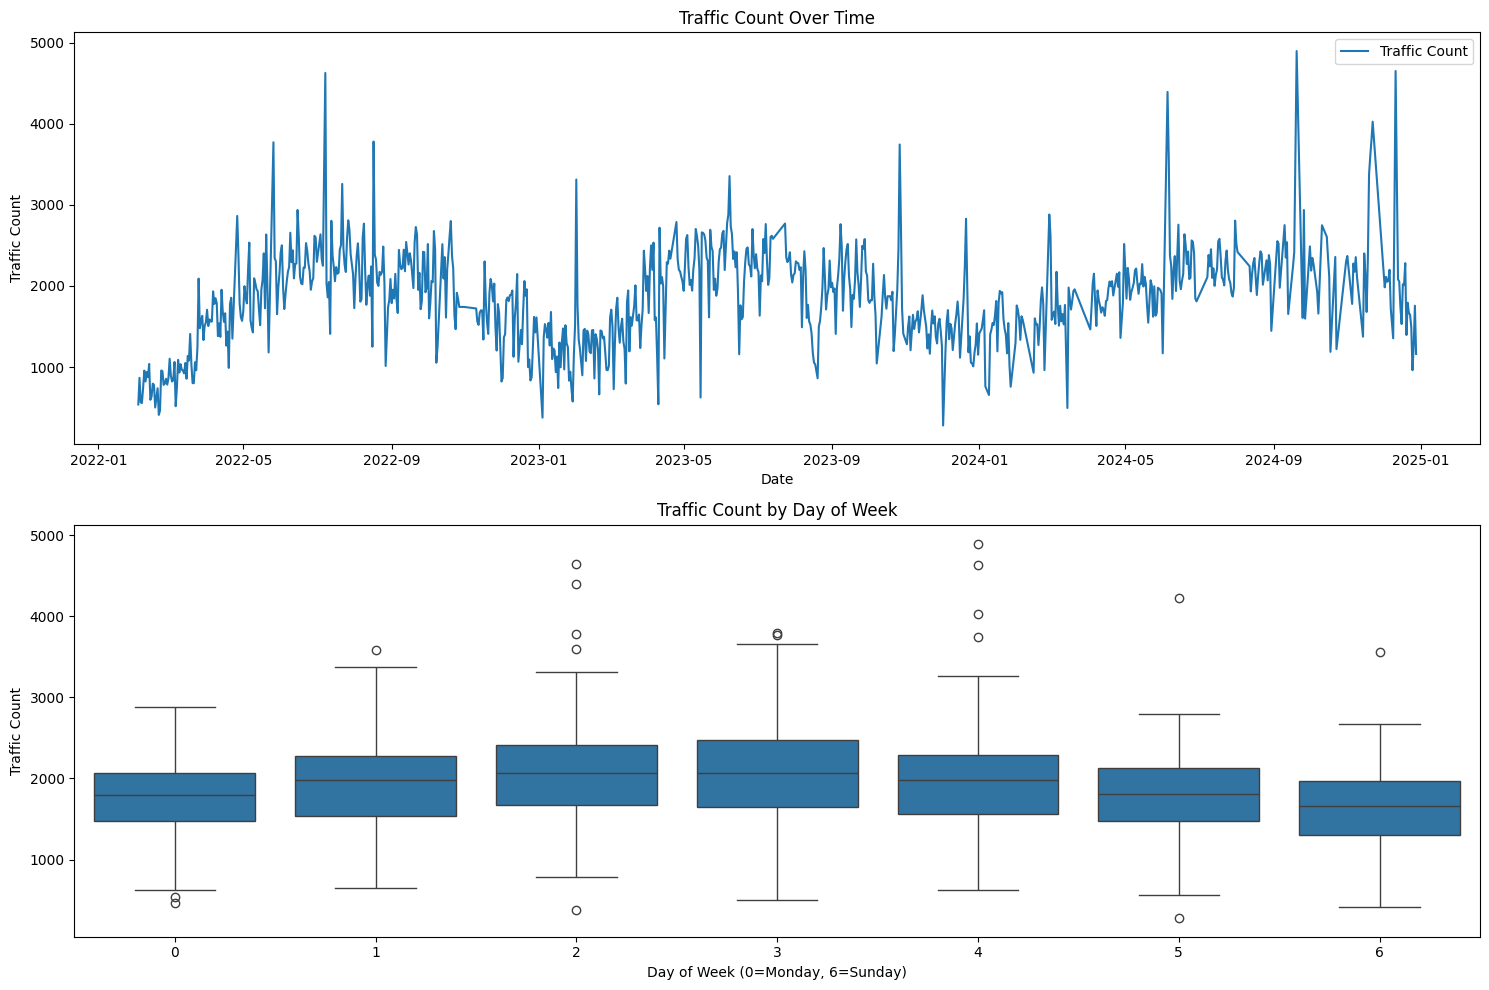

In [174]:
#visualizing the data
visualize_traffic_data(traffic_data)

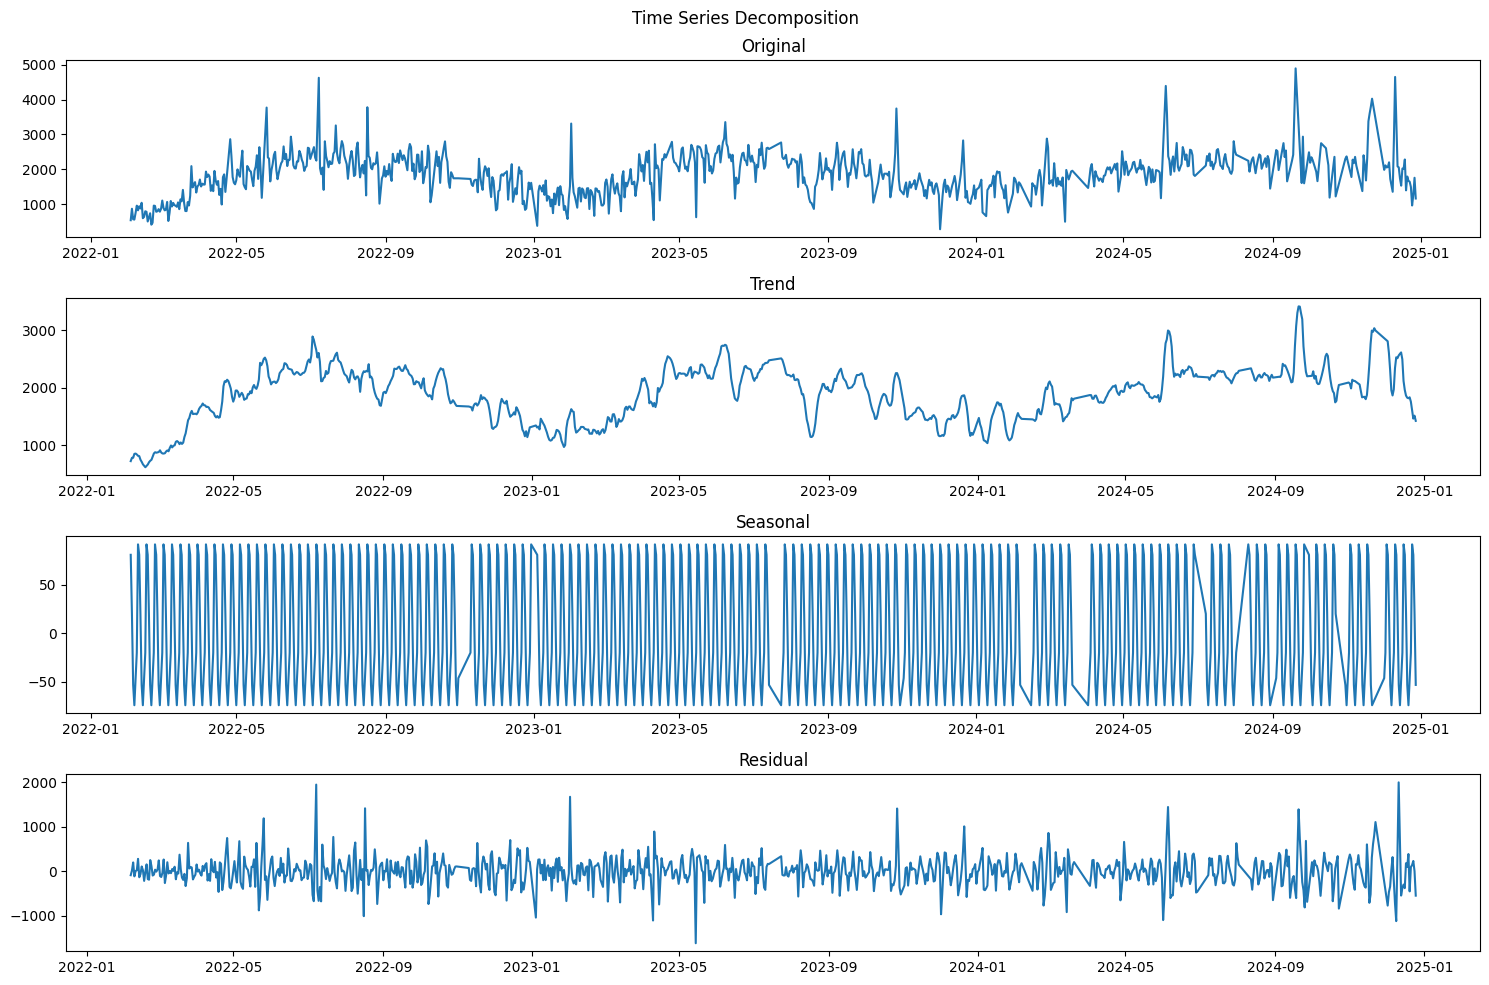

In [175]:
#performing the time series decomposition
decompose_time_series(traffic_data)

In [176]:
#scaling the features and preparing them to enter the model
X, y = prepare_ml_features(traffic_data)

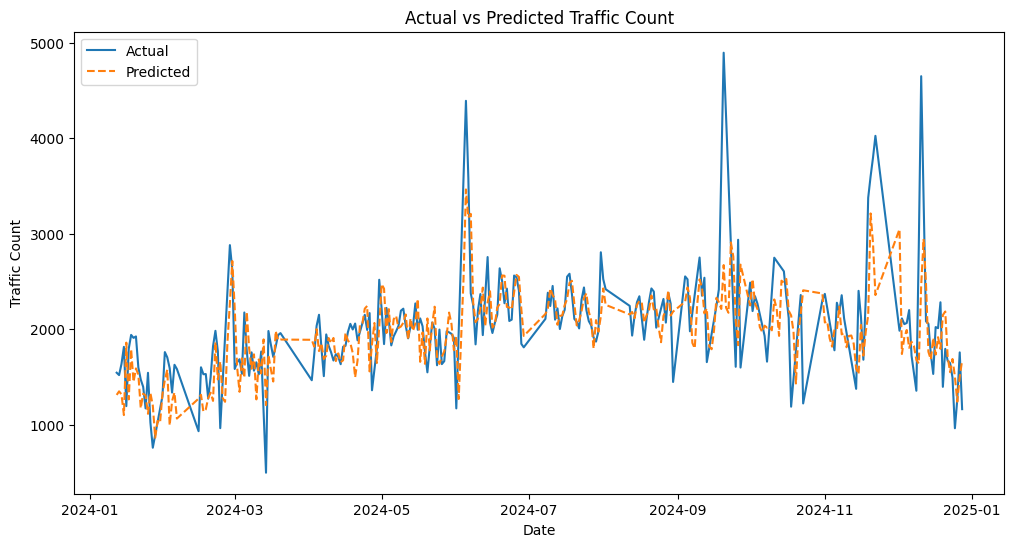

In [177]:
#training and running the model
rf_metrics, model, scaler = train_and_evaluate_rf_model(X, y)

In [178]:
#computing the model performance
print("Model Performance Metrics:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value}")

Model Performance Metrics:
MAE: 301.59599315068493
RMSE: 448.9410676433833
R2: 0.395038675909693
Std Dev: 442.17079478417725


In [179]:
#predicting the next periods
predictions = predict_future_periods(model, scaler, X, y)

print("Predicted Traffic Counts:")
print(predictions)

Predicted Traffic Counts:
2024-12-29    1673.09
2024-12-30    1786.85
2024-12-31     876.06
2025-01-01     873.00
2025-01-02    1292.81
Freq: D, dtype: float64


## Convolutional Neural Network Implementation

In [180]:
#preparing the data for CNN
def prepare_cnn_data(X, y):
    #CNN needs a 3D input: (samples, time steps, features)
    X_reshaped = X.values.reshape(X.shape[0], X.shape[1], 1)
    return X_reshaped, y

In [181]:
#preprocessing the data for cnn by splitting it into the 80/20 test split and scaling it
def preprocess_data_for_cnn(X, y):

    #splitting training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    #scaling the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #reshaping the data for CNN
    X_train_cnn, y_train_cnn = prepare_cnn_data(pd.DataFrame(X_train_scaled), y_train)
    X_test_cnn, y_test_cnn = prepare_cnn_data(pd.DataFrame(X_test_scaled), y_test)

    return X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn, scaler

In [182]:
#building the CNN model
def build_cnn_model(input_shape):

    model = Sequential([
        Input(shape=input_shape),  # Explicit input layer
        Conv1D(filters=64, kernel_size=2, activation='relu'),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=2, activation='relu'),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)  # Single output for regression
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [183]:
#training the CNN model
#small datasets recommend batch size of 8, 16, 32, Epochs should be 10-30, learning rate 0.001 (adam)
def train_cnn_model(X_train, y_train, X_val, y_val, input_shape, epochs=30, batch_size=16):

    model = build_cnn_model(input_shape)
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=epochs, batch_size=batch_size, verbose=2)
    return model

In [184]:
#evaluating the CNN model
def evaluate_model(model, X_test, y_test, visualize):

    #making predictions
    y_pred = model.predict(X_test).flatten()

    #evaluating metrics
    CNN_metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

    if vizualize == 1:
        #plotting predictions
        plt.figure(figsize=(12, 6))
        plt.plot(y_test.index, y_test.values, label='Actual')
        plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
        plt.title('Actual vs Predicted Traffic Count')
        plt.xlabel('Date')
        plt.ylabel('Traffic Count')
        plt.legend()
        plt.show()

    return CNN_metrics


In [185]:
#preprocessing the data for CNN
X_train, X_test, y_train, y_test, scaler = preprocess_data_for_cnn(X, y)

In [186]:
#training the CNN model
input_shape = (X_train.shape[1], X_train.shape[2])
cnn_model = train_cnn_model(X_train, y_train, X_test, y_test, input_shape, epochs=50)

Epoch 1/50
49/49 - 2s - 46ms/step - loss: 3506566.0000 - mae: 1784.6560 - val_loss: 5001528.0000 - val_mae: 2158.8997
Epoch 2/50
49/49 - 0s - 5ms/step - loss: 2511203.7500 - mae: 1467.1237 - val_loss: 1761084.5000 - val_mae: 1189.5027
Epoch 3/50
49/49 - 0s - 6ms/step - loss: 416333.2500 - mae: 514.2765 - val_loss: 443507.1875 - val_mae: 480.7244
Epoch 4/50
49/49 - 0s - 6ms/step - loss: 293217.2500 - mae: 425.3126 - val_loss: 420727.7500 - val_mae: 467.0941
Epoch 5/50
49/49 - 0s - 5ms/step - loss: 296012.5312 - mae: 428.1010 - val_loss: 455607.5938 - val_mae: 487.6190
Epoch 6/50
49/49 - 0s - 6ms/step - loss: 292663.0625 - mae: 427.0555 - val_loss: 403130.6250 - val_mae: 455.4968
Epoch 7/50
49/49 - 0s - 7ms/step - loss: 285001.6250 - mae: 419.1994 - val_loss: 432565.9062 - val_mae: 471.4920
Epoch 8/50
49/49 - 0s - 6ms/step - loss: 286907.3125 - mae: 421.7334 - val_loss: 422687.9688 - val_mae: 464.4268
Epoch 9/50
49/49 - 0s - 6ms/step - loss: 278330.0625 - mae: 413.0703 - val_loss: 422666

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


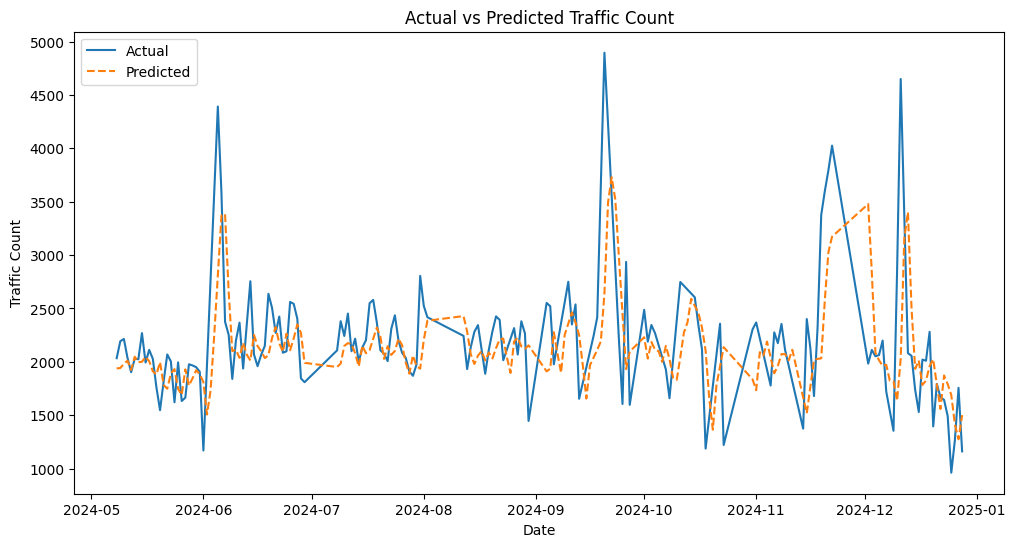

CNN Model Performance Metrics:
MAE: 348.4412347255609
RMSE: 514.4221666219385
R2: 0.22429216285369225


In [187]:
#evaluating the model
vizualize = 1
CNN_metrics = evaluate_model(cnn_model, X_test, y_test, vizualize)
print("CNN Model Performance Metrics:")
for metric, value in CNN_metrics.items():
    print(f"{metric}: {value}")

## Super cool additional attempt:

In [192]:
from sklearn.preprocessing import MinMaxScaler

# Reshape X_train and X_test to 2D (Flatten the last dimension)
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))
X_test_reshaped = X_test.reshape((X_test.shape[0], -1))

# Apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to 3D for LSTM
X_train_lstm = X_train_scaled.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test.shape[0], X_test.shape[1], 1))


# Define the LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')
# Train the LSTM model
history_lstm = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 3533916.7500 - val_loss: 5170280.5000
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3580473.0000 - val_loss: 5143927.0000
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3499566.5000 - val_loss: 5120182.0000
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3449686.0000 - val_loss: 5097338.0000
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3466980.7500 - val_loss: 5074831.0000
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3354418.2500 - val_loss: 5053003.0000
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3360257.0000 - val_loss: 5031235.0000
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3415326.7500 - val_loss: 5009617.5000
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3298278.5000 - val_loss: 4988272.0000
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3279599.5000 - val_loss: 4967094.0000
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1

In [193]:
# Make predictions
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

# Print the evaluation metrics
print(f'LSTM Model Performance:\\nMAE: {mae_lstm}\\nMSE: {mse_lstm}\\nR2 Score: {r2_lstm}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
LSTM Model Performance:\nMAE: 1961.2589709942158\nMSE: 4187683.2037177444\nR2 Score: -11.275315152846371


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


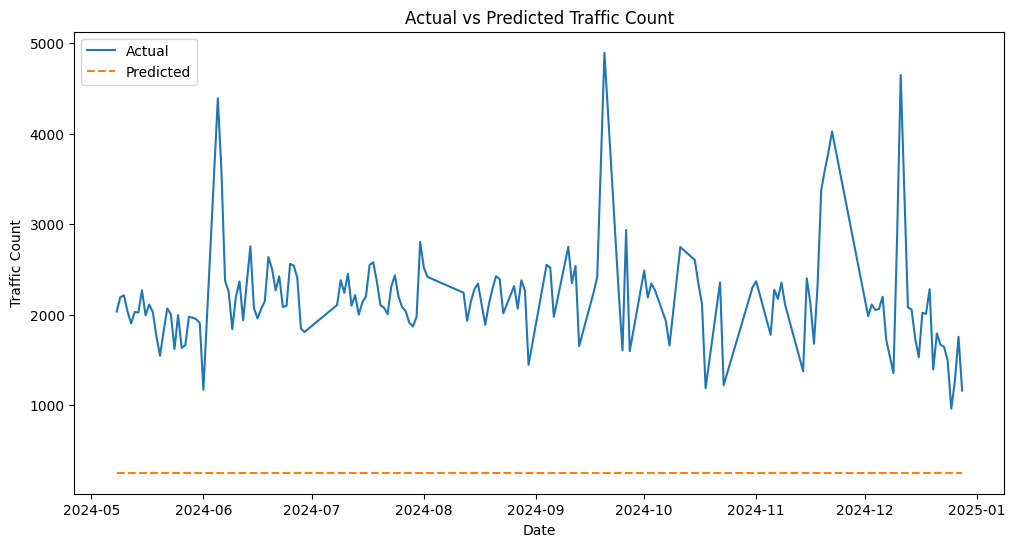

LSTM Model Performance Metrics:
MAE: 1961.2589709942158
RMSE: 2046.3829562713192
R2: -11.275315152846371


In [194]:
# Evaluating the LSTM model
vizualize = 1  # Assuming this controls visualization

LSTM_metrics = evaluate_model(lstm_model, X_test_lstm, y_test, vizualize)
print("LSTM Model Performance Metrics:")
for metric, value in LSTM_metrics.items():
    print(f"{metric}: {value}")

# LSTM

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 3598856.7500 - val_loss: 5039075.0000
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2190389.2500 - val_loss: 281421.4688
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 230117.1406 - val_loss: 288746.9062
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 204229.0469 - val_loss: 295245.2812
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 205632.1562 - val_loss: 301063.3125
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 195507.2344 - val_loss: 272750.0000
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 234647.5312 - val_loss: 294887.1875
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 205519.8594 - val_loss: 272179.8125
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 227628.9688 - val_loss: 296997.6875
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 211670.6406 - val_loss: 285824.5312
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - los

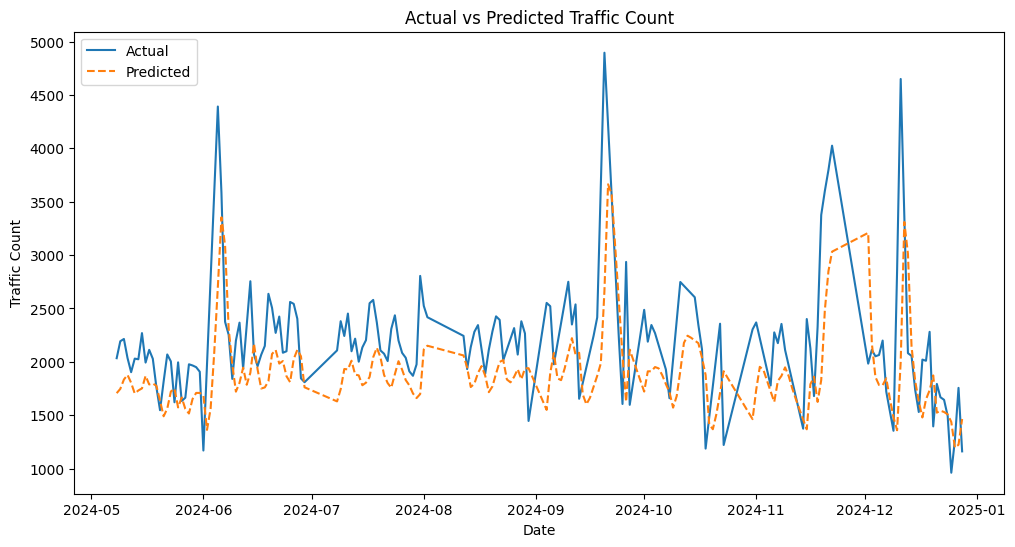

LSTM Model Performance Metrics:
MAE: 420.1586219200721
RMSE: 571.2162966183345
R2: 0.043554982110089235


In [196]:
from sklearn.preprocessing import MinMaxScaler

# Reshape X_train and X_test to 2D (Flatten the last dimension)
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))
X_test_reshaped = X_test.reshape((X_test.shape[0], -1))

# Apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to 3D for LSTM
X_train_lstm = X_train_scaled.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test.shape[0], X_test.shape[1], 1))


# Define the LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')
# Train the LSTM model
history_lstm = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test))

# Make predictions
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

# Print the evaluation metrics
print(f'LSTM Model Performance:\\nMAE: {mae_lstm}\\nMSE: {mse_lstm}\\nR2 Score: {r2_lstm}')

# Evaluating the LSTM model
vizualize = 1  # Assuming this controls visualization

LSTM_metrics = evaluate_model(lstm_model, X_test_lstm, y_test, vizualize)
print("LSTM Model Performance Metrics:")
for metric, value in LSTM_metrics.items():
    print(f"{metric}: {value}")

## Comparing the metrics to determine the best model

Random Forest Model Performance Metrics:
MAE: 301.59599315068493
RMSE: 448.9410676433833
R2: 0.395038675909693
Std Dev: 442.17079478417725
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

CNN Model Performance Metrics:
MAE: 348.4412347255609
RMSE: 514.4221666219385
R2: 0.22429216285369225
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

LSTM Model Performance Metrics:
MAE: 1961.2589709942158
RMSE: 2046.3829562713192
R2: -11.275315152846371


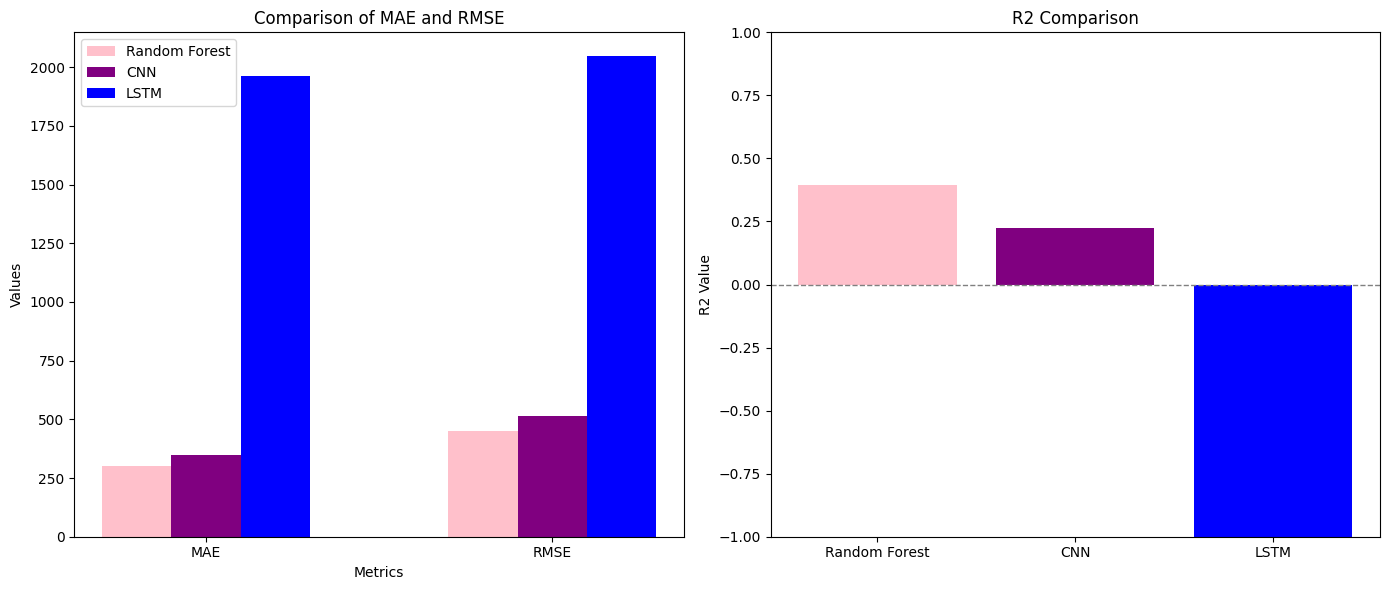


The Random Forest model outperforms the CNN and LSTM models based on the metrics.


In [195]:
# Evaluating LSTM model


# Evaluating Random Forest model again
print("Random Forest Model Performance Metrics:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value}")

# Evaluating CNN model
vizualize = 0
cnn_metrics = evaluate_model(cnn_model, X_test, y_test, vizualize)
print("\nCNN Model Performance Metrics:")
for metric, value in cnn_metrics.items():
    print(f"{metric}: {value}")

vizualize = 0  # Keeping visualization off for now
lstm_metrics = evaluate_model(lstm_model, X_test_lstm, y_test, vizualize)
print("\nLSTM Model Performance Metrics:")
for metric, value in lstm_metrics.items():
    print(f"{metric}: {value}")

# Extracting metrics for comparison
metrics_names = ['MAE', 'RMSE']
rf_values = [rf_metrics[metric] for metric in metrics_names]
cnn_values = [cnn_metrics[metric] for metric in metrics_names]
lstm_values = [lstm_metrics[metric] for metric in metrics_names]

rf_r2 = rf_metrics['R2']
cnn_r2 = cnn_metrics['R2']
lstm_r2 = lstm_metrics['R2']


# Setting up a bar graph for MAE and RMSE
x = np.arange(len(metrics_names))  # The label locations
width = 0.2  # Reduce width to fit LSTM

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart for MAE and RMSE
axs[0].bar(x - width, rf_values, width, label='Random Forest', color='pink')
axs[0].bar(x, cnn_values, width, label='CNN', color='purple')
axs[0].bar(x + width, lstm_values, width, label='LSTM', color='blue')

# Adding labels, title, and legend
axs[0].set_xlabel('Metrics')
axs[0].set_ylabel('Values')
axs[0].set_title('Comparison of MAE and RMSE')
axs[0].set_xticks(x)
axs[0].set_xticklabels(metrics_names)
axs[0].legend()


# Bar chart for R2
r2_models = ['Random Forest', 'CNN', 'LSTM']
r2_values = [rf_r2, cnn_r2, lstm_r2]
axs[1].bar(r2_models, r2_values, color=['pink', 'purple', 'blue'])

# Adding labels, title, and scale
axs[1].set_ylabel('R2 Value')
axs[1].set_title('R2 Comparison')
axs[1].set_ylim(-1, 1)  # Scale from -1 to 1
axs[1].axhline(0, color='gray', linestyle='--', linewidth=1)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# Comparing the metrics and deciding the best model
if (
    lstm_metrics['MAE'] < cnn_metrics['MAE'] and lstm_metrics['MAE'] < rf_metrics['MAE'] and
    lstm_metrics['RMSE'] < cnn_metrics['RMSE'] and lstm_metrics['RMSE'] < rf_metrics['RMSE'] and
    lstm_metrics['R2'] > cnn_metrics['R2'] and lstm_metrics['R2'] > rf_metrics['R2']
):
    print("\nThe LSTM model outperforms both CNN and Random Forest based on the metrics.")
elif (
    cnn_metrics['MAE'] < rf_metrics['MAE'] and cnn_metrics['RMSE'] < rf_metrics['RMSE'] and cnn_metrics['R2'] > rf_metrics['R2']
):
    print("\nThe CNN model outperforms the Random Forest model based on the metrics.")
else:
    print("\nThe Random Forest model outperforms the CNN and LSTM models based on the metrics.")

